In [ ]:
import os

import glob
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt

In [2]:
import numpy as np

def train_test_split(arr, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    arr = np.array(arr)
    n = len(arr)
    idx = np.random.permutation(n)
    split = int(n * (1 - test_size))
    return arr[idx[:split]], arr[idx[split:]]


In [3]:
# Base paths
TRAIN_PATH = r"./Brats-2020/MICCAI_BraTS2020_TrainingData"
VAL_PATH   = r"./Brats-2020/MICCAI_BraTS2020_ValidationData"
OUTPUT_PATH = r"./preprocessed"
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Image params
IMG_SIZE = 240
N_MODALITIES = 4         # T1, T1CE, T2, FLAIR
N_CLASSES = 4            # background + 3 tumor labels
VOLUME_START_AT = 20
VOLUME_SLICES = 128


In [4]:
import numpy as np
import nibabel as nib
import cv2
import glob
import torch

def load_modalities(case_dir):
    flair = nib.load(glob.glob(case_dir + "/*_flair.nii")[0]).get_fdata()
    t1    = nib.load(glob.glob(case_dir + "/*_t1.nii")[0]).get_fdata()
    t1ce  = nib.load(glob.glob(case_dir + "/*_t1ce.nii")[0]).get_fdata()
    t2    = nib.load(glob.glob(case_dir + "/*_t2.nii")[0]).get_fdata()
    seg   = nib.load(glob.glob(case_dir + "/*_seg.nii")[0]).get_fdata()
    return flair, t1, t1ce, t2, seg


def preprocess_case(case_dir, case_id):
    flair, t1, t1ce, t2, seg = load_modalities(case_dir)

    X, Y = [], []
    depth = flair.shape[2]

    for k in range(VOLUME_START_AT, VOLUME_START_AT + VOLUME_SLICES):

        # ------------ IMAGE ------------
        img = np.stack([
            cv2.resize(t1[:,:,k],    (IMG_SIZE, IMG_SIZE)),
            cv2.resize(t1ce[:,:,k],  (IMG_SIZE, IMG_SIZE)),
            cv2.resize(t2[:,:,k],    (IMG_SIZE, IMG_SIZE)),
            cv2.resize(flair[:,:,k], (IMG_SIZE, IMG_SIZE)),
        ], axis=-1).astype(np.float32)

        # Standardize
        img = (img - img.mean()) / (img.std() + 1e-8)

        # ------------ MASK -------------
        mask = cv2.resize(seg[:,:,k], (IMG_SIZE, IMG_SIZE))

        # Remap labels: 4 → 3 (Enhancing Tumor)
        mask[mask == 4] = 3

        # Replace keras.utils.to_categorical
        # New: one-hot with NumPy
        mask_onehot = np.eye(4)[mask.astype(np.int32)]  # shape (H, W, 4)

        X.append(img)
        Y.append(mask_onehot.astype(np.float32))

    np.save(f"{OUTPUT_PATH}/{case_id}_images.npy", np.array(X))
    np.save(f"{OUTPUT_PATH}/{case_id}_masks.npy",  np.array(Y))

    print(f"Processed {case_id} → slices: {len(X)}")


### Uncomment the following code block for first time execution.

In [ ]:
# train_cases = sorted([d for d in os.listdir(TRAIN_PATH) if "BraTS20" in d])

# # train_cases = train_cases[0:300]
# train_cases = [c for c in train_cases if "355" not in c]

# for cid in train_cases:
#     print(cid)
#     preprocess_case(os.path.join(TRAIN_PATH, cid), cid)


In [7]:
import torch
from torch.utils.data import Dataset
import numpy as np
import random

class FastBraTSDataset(Dataset):
    def __init__(self, case_ids, output_path, augment=False):
        self.augment = augment

        self.X = []   # all images
        self.Y = []   # all masks

        # Load each case ONCE
        for cid in case_ids:
            imgs = np.load(f"{output_path}/{cid}_images.npy")
            masks = np.load(f"{output_path}/{cid}_masks.npy")
            
            for i in range(len(imgs)):
                self.X.append(imgs[i])
                self.Y.append(masks[i])

        self.X = np.array(self.X)
        self.Y = np.array(self.Y)

        print("Loaded into RAM:", self.X.shape, self.Y.shape)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        mask = self.Y[idx]

        # Convert to torch & channels-first
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)

        if self.augment:
            img, mask = self.apply_augment(img, mask)

        return img, mask.argmax(0)

    def apply_augment(self, X, Y):
        # Flip horizontally
        if random.random() > 0.5:
            X = torch.flip(X, dims=[2])
            Y = torch.flip(Y, dims=[2])

        # Random rotation (0,1,2,3)
        k = random.randint(0, 3)
        X = torch.rot90(X, k, dims=[1, 2])
        Y = torch.rot90(Y, k, dims=[1, 2])

        # Brightness
        if random.random() > 0.7:
            factor = random.uniform(0.9, 1.1)
            X = X * factor

        return X, Y


In [8]:
cases = sorted([d for d in os.listdir(TRAIN_PATH) if "BraTS20" in d])

# cases = cases[:300] 
cases = [c for c in cases if "355" not in c]

train_ids, test_ids = train_test_split(cases, test_size=0.15, random_state=42)
train_ids, val_ids  = train_test_split(train_ids, test_size=0.20, random_state=42)

print("Train:", len(train_ids))
print("Val  :", len(val_ids))
print("Test :", len(test_ids))


Train: 249
Val  : 63
Test : 56


In [9]:
from torch.utils.data import DataLoader

train_set = FastBraTSDataset(
    case_ids=train_ids,
    output_path=OUTPUT_PATH,
    augment=True
)

val_set = FastBraTSDataset(
    case_ids=val_ids,
    output_path=OUTPUT_PATH,
    augment=False
)

train_loader = DataLoader(
    train_set,
    batch_size=16,
    shuffle=True,
    num_workers=0,  
    pin_memory=True
)

val_loader = DataLoader(
    val_set,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


Loaded into RAM: (31872, 240, 240, 4) (31872, 240, 240, 4)
Loaded into RAM: (8064, 240, 240, 4) (8064, 240, 240, 4)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNet(nn.Module):
    def __init__(self, in_channels=4, n_classes=4):
        super().__init__()

        # Encoder
        self.c1 = ConvBlock(in_channels, 32)
        self.p1 = nn.MaxPool2d(2)

        self.c2 = ConvBlock(32, 64)
        self.p2 = nn.MaxPool2d(2)

        self.c3 = ConvBlock(64, 128)
        self.p3 = nn.MaxPool2d(2)

        self.c4 = ConvBlock(128, 256)
        self.p4 = nn.MaxPool2d(2)

        # Bridge
        self.bn = ConvBlock(256, 512)

        # Decoder (UpSampling2D + concat)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.c5  = ConvBlock(512 + 256, 256)

        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.c6  = ConvBlock(256 + 128, 128)

        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.c7  = ConvBlock(128 + 64, 64)

        self.up4 = nn.Upsample(scale_factor=2, mode='nearest')
        self.c8  = ConvBlock(64 + 32, 32)

        # Output
        self.out_conv = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        # x: (B, 4, 240, 240)

        # Encoder
        c1 = self.c1(x)
        p1 = self.p1(c1)

        c2 = self.c2(p1)
        p2 = self.p2(c2)

        c3 = self.c3(p2)
        p3 = self.p3(c3)

        c4 = self.c4(p3)
        p4 = self.p4(c4)

        # Bridge
        bn = self.bn(p4)

        # Decoder
        u1 = self.up1(bn)
        u1 = torch.cat([u1, c4], dim=1)
        c5 = self.c5(u1)

        u2 = self.up2(c5)
        u2 = torch.cat([u2, c3], dim=1)
        c6 = self.c6(u2)

        u3 = self.up3(c6)
        u3 = torch.cat([u3, c2], dim=1)
        c7 = self.c7(u3)

        u4 = self.up4(c7)
        u4 = torch.cat([u4, c1], dim=1)
        c8 = self.c8(u4)

        logits = self.out_conv(c8)   # (B, 4, 240, 240)
        return logits


In [11]:
model = UNet(in_channels=4, n_classes=4).cuda()
# Check if model is on GPU
print("Model device:", next(model.parameters()).device)
from torchinfo import summary

summary(model, input_size=(1, 4, 240, 240))


Model device: cuda:0


Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 4, 240, 240]          --
├─ConvBlock: 1-1                         [1, 32, 240, 240]         --
│    └─Sequential: 2-1                   [1, 32, 240, 240]         --
│    │    └─Conv2d: 3-1                  [1, 32, 240, 240]         1,184
│    │    └─BatchNorm2d: 3-2             [1, 32, 240, 240]         64
│    │    └─ReLU: 3-3                    [1, 32, 240, 240]         --
│    │    └─Conv2d: 3-4                  [1, 32, 240, 240]         9,248
│    │    └─BatchNorm2d: 3-5             [1, 32, 240, 240]         64
│    │    └─ReLU: 3-6                    [1, 32, 240, 240]         --
├─MaxPool2d: 1-2                         [1, 32, 120, 120]         --
├─ConvBlock: 1-3                         [1, 64, 120, 120]         --
│    └─Sequential: 2-2                   [1, 64, 120, 120]         --
│    │    └─Conv2d: 3-7                  [1, 64, 120, 120]         18,496
│    

In [12]:
import torch
import torch.nn.functional as F
import torch.nn as nn

# CrossEntropyLoss for multi-class segmentation
ce_loss = nn.CrossEntropyLoss()

def dice_coef(y_pred, y_true, smooth=1e-6):
    """
    y_pred: raw logits from U-Net         (B, C, H, W)
    y_true: label map (0..3)              (B, H, W)
    """

    # Convert y_true → one-hot same as TF/Keras to_categorical
    y_true_onehot = F.one_hot(y_true, num_classes=4)   # (B, H, W, C)
    y_true_onehot = y_true_onehot.permute(0, 3, 1, 2).float()  # (B, C, H, W)

    # Softmax over channel dimension (like TF softmax)
    y_pred_soft = torch.softmax(y_pred, dim=1)

    # Flatten (like K.flatten)
    y_pred_f = y_pred_soft.reshape(y_pred_soft.size(0), 4, -1)
    y_true_f = y_true_onehot.reshape(y_true_onehot.size(0), 4, -1)

    # Intersection & union per class
    intersection = (y_pred_f * y_true_f).sum(dim=2)
    union = y_pred_f.sum(dim=2) + y_true_f.sum(dim=2)

    # Dice score per class
    dice = (2 * intersection + smooth) / (union + smooth)

    # Mean over classes, then batch
    return dice.mean()


def dice_loss(y_pred, y_true):
    return 1 - dice_coef(y_pred, y_true)


def combined_loss(y_pred, y_true):
    """
    CrossEntropy + Dice Loss (same as your Keras combined_loss)
    y_pred: logits
    y_true: integer labels
    """
    ce = ce_loss(y_pred, y_true)
    dl = dice_loss(y_pred, y_true)
    return ce + dl


In [ ]:
import torch

class EarlyStopping:
    def __init__(self, patience=6, mode="max"):
        self.patience = patience
        self.mode = mode
        self.best = None
        self.counter = 0
        self.should_stop = False

    def step(self, metric):
        if self.best is None:
            self.best = metric
            return

        improvement = (metric > self.best) if self.mode == "max" else (metric < self.best)

        if improvement:
            self.best = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=3,
    # verbose=True
)


In [25]:
from tqdm import tqdm

num_epochs = 40
early_stopper = EarlyStopping(patience=6, mode="max")

history = {
    "train_loss": [],
    "val_loss": [],
    "train_dice": [],
    "val_dice": []
}

best_val_dice = -1
best_model_path = "best_model.pth"

for epoch in range(num_epochs):
    print(f"\nEPOCH {epoch+1}/{num_epochs}")
    
    # ---------------------- TRAIN ----------------------
    model.train()
    train_loss = 0
    train_dice = 0

    for X, Y in tqdm(train_loader):
        X = X.cuda()
        Y = Y.cuda()

        optimizer.zero_grad()
        pred = model(X)

        loss = combined_loss(pred, Y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_coef(pred, Y).item()

    train_loss /= len(train_loader)
    train_dice /= len(train_loader)

    # ---------------------- VALIDATION ----------------------
    model.eval()
    val_loss = 0
    val_dice = 0

    with torch.no_grad():
        for X, Y in val_loader:
            X = X.cuda()
            Y = Y.cuda()

            pred = model(X)
            loss = combined_loss(pred, Y)

            val_loss += loss.item()
            val_dice += dice_coef(pred, Y).item()

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)

    # Record history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_dice"].append(train_dice)
    history["val_dice"].append(val_dice)

    print(f"Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f}")
    print(f"Val Loss  : {val_loss:.4f} | Val Dice  : {val_dice:.4f}")

    # ---------------------- CHECKPOINT ----------------------
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), best_model_path)
        print("Saved Best Model!")

    # ---------------------- Early Stopping ----------------------
    early_stopper.step(val_dice)
    if early_stopper.should_stop:
        print("Early stopping triggered!")
        break

    # ---------------------- Reduce LR on Plateau ----------------------
    scheduler.step(val_loss)



EPOCH 1/40


100%|██████████| 1992/1992 [09:29<00:00,  3.50it/s]


Train Loss: 0.9962 | Train Dice: 0.2707
Val Loss  : 0.6726 | Val Dice  : 0.3739
Saved Best Model!

EPOCH 2/40


100%|██████████| 1992/1992 [14:31<00:00,  2.29it/s]


Train Loss: 0.6290 | Train Dice: 0.3978
Val Loss  : 0.6074 | Val Dice  : 0.4194
Saved Best Model!

EPOCH 3/40


100%|██████████| 1992/1992 [11:01<00:00,  3.01it/s]


Train Loss: 0.5921 | Train Dice: 0.4252
Val Loss  : 0.5940 | Val Dice  : 0.4297
Saved Best Model!

EPOCH 4/40


100%|██████████| 1992/1992 [12:53<00:00,  2.58it/s] 


Train Loss: 0.5821 | Train Dice: 0.4333
Val Loss  : 0.5862 | Val Dice  : 0.4367
Saved Best Model!

EPOCH 5/40


100%|██████████| 1992/1992 [15:30<00:00,  2.14it/s]


Train Loss: 0.5764 | Train Dice: 0.4381
Val Loss  : 0.5831 | Val Dice  : 0.4386
Saved Best Model!

EPOCH 6/40


100%|██████████| 1992/1992 [11:30<00:00,  2.88it/s]


Train Loss: 0.5724 | Train Dice: 0.4413
Val Loss  : 0.5846 | Val Dice  : 0.4380

EPOCH 7/40


100%|██████████| 1992/1992 [09:31<00:00,  3.49it/s]


Train Loss: 0.5694 | Train Dice: 0.4438
Val Loss  : 0.5856 | Val Dice  : 0.4394
Saved Best Model!

EPOCH 8/40


100%|██████████| 1992/1992 [09:51<00:00,  3.37it/s]


Train Loss: 0.5672 | Train Dice: 0.4456
Val Loss  : 0.5798 | Val Dice  : 0.4420
Saved Best Model!

EPOCH 9/40


100%|██████████| 1992/1992 [11:06<00:00,  2.99it/s]


Train Loss: 0.5652 | Train Dice: 0.4472
Val Loss  : 0.5788 | Val Dice  : 0.4424
Saved Best Model!

EPOCH 10/40


100%|██████████| 1992/1992 [10:44<00:00,  3.09it/s]


Train Loss: 0.5309 | Train Dice: 0.4813
Val Loss  : 0.5351 | Val Dice  : 0.4891
Saved Best Model!

EPOCH 11/40


100%|██████████| 1992/1992 [11:16<00:00,  2.94it/s]


Train Loss: 0.4991 | Train Dice: 0.5148
Val Loss  : 0.4020 | Val Dice  : 0.6385
Saved Best Model!

EPOCH 12/40


100%|██████████| 1992/1992 [14:43<00:00,  2.26it/s]


Train Loss: 0.2648 | Train Dice: 0.7671
Val Loss  : 0.2041 | Val Dice  : 0.8452
Saved Best Model!

EPOCH 13/40


100%|██████████| 1992/1992 [14:31<00:00,  2.29it/s]


Train Loss: 0.1662 | Train Dice: 0.8646
Val Loss  : 0.2167 | Val Dice  : 0.8330

EPOCH 14/40


100%|██████████| 1992/1992 [16:03<00:00,  2.07it/s] 


Train Loss: 0.1597 | Train Dice: 0.8699
Val Loss  : 0.1894 | Val Dice  : 0.8548
Saved Best Model!

EPOCH 15/40


100%|██████████| 1992/1992 [11:29<00:00,  2.89it/s]


Train Loss: 0.1527 | Train Dice: 0.8751
Val Loss  : 0.1884 | Val Dice  : 0.8619
Saved Best Model!

EPOCH 16/40


100%|██████████| 1992/1992 [11:42<00:00,  2.83it/s]


Train Loss: 0.1476 | Train Dice: 0.8792
Val Loss  : 0.1894 | Val Dice  : 0.8586

EPOCH 17/40


100%|██████████| 1992/1992 [11:04<00:00,  3.00it/s]


Train Loss: 0.1521 | Train Dice: 0.8760
Val Loss  : 0.1825 | Val Dice  : 0.8514

EPOCH 18/40


100%|██████████| 1992/1992 [10:18<00:00,  3.22it/s]


Train Loss: 0.1510 | Train Dice: 0.8764
Val Loss  : 0.1969 | Val Dice  : 0.8557

EPOCH 19/40


100%|██████████| 1992/1992 [09:57<00:00,  3.33it/s]


Train Loss: 0.1443 | Train Dice: 0.8803
Val Loss  : 0.1956 | Val Dice  : 0.8379

EPOCH 20/40


100%|██████████| 1992/1992 [10:51<00:00,  3.06it/s]


Train Loss: 0.1455 | Train Dice: 0.8795
Val Loss  : 0.2036 | Val Dice  : 0.8636
Saved Best Model!

EPOCH 21/40


100%|██████████| 1992/1992 [12:48<00:00,  2.59it/s]


Train Loss: 0.1483 | Train Dice: 0.8784
Val Loss  : 0.1844 | Val Dice  : 0.8588

EPOCH 22/40


100%|██████████| 1992/1992 [17:01<00:00,  1.95it/s]


Train Loss: 0.1339 | Train Dice: 0.8877
Val Loss  : 0.1678 | Val Dice  : 0.8685
Saved Best Model!

EPOCH 23/40


100%|██████████| 1992/1992 [15:59<00:00,  2.08it/s]


Train Loss: 0.1295 | Train Dice: 0.8901
Val Loss  : 0.1562 | Val Dice  : 0.8750
Saved Best Model!

EPOCH 24/40


100%|██████████| 1992/1992 [12:01<00:00,  2.76it/s]


Train Loss: 0.1281 | Train Dice: 0.8909
Val Loss  : 0.1782 | Val Dice  : 0.8746

EPOCH 25/40


100%|██████████| 1992/1992 [09:58<00:00,  3.33it/s]


Train Loss: 0.1280 | Train Dice: 0.8909
Val Loss  : 0.1769 | Val Dice  : 0.8688

EPOCH 26/40


100%|██████████| 1992/1992 [11:22<00:00,  2.92it/s]


Train Loss: 0.1303 | Train Dice: 0.8912
Val Loss  : 0.1695 | Val Dice  : 0.8746

EPOCH 27/40


100%|██████████| 1992/1992 [13:33<00:00,  2.45it/s]


Train Loss: 0.1274 | Train Dice: 0.8921
Val Loss  : 0.1638 | Val Dice  : 0.8736

EPOCH 28/40


100%|██████████| 1992/1992 [23:36<00:00,  1.41it/s]


Train Loss: 0.1208 | Train Dice: 0.8972
Val Loss  : 0.1579 | Val Dice  : 0.8771
Saved Best Model!

EPOCH 29/40


100%|██████████| 1992/1992 [15:06<00:00,  2.20it/s] 


Train Loss: 0.1186 | Train Dice: 0.8985
Val Loss  : 0.1621 | Val Dice  : 0.8768

EPOCH 30/40


100%|██████████| 1992/1992 [10:40<00:00,  3.11it/s]


Train Loss: 0.1178 | Train Dice: 0.8993
Val Loss  : 0.1641 | Val Dice  : 0.8770

EPOCH 31/40


100%|██████████| 1992/1992 [09:48<00:00,  3.39it/s]


Train Loss: 0.1171 | Train Dice: 0.8991
Val Loss  : 0.1582 | Val Dice  : 0.8759

EPOCH 32/40


100%|██████████| 1992/1992 [09:15<00:00,  3.59it/s]


Train Loss: 0.1145 | Train Dice: 0.9015
Val Loss  : 0.1564 | Val Dice  : 0.8804
Saved Best Model!

EPOCH 33/40


100%|██████████| 1992/1992 [09:16<00:00,  3.58it/s]


Train Loss: 0.1126 | Train Dice: 0.9023
Val Loss  : 0.1543 | Val Dice  : 0.8783

EPOCH 34/40


100%|██████████| 1992/1992 [09:14<00:00,  3.59it/s]


Train Loss: 0.1133 | Train Dice: 0.9018
Val Loss  : 0.1586 | Val Dice  : 0.8808
Saved Best Model!

EPOCH 35/40


100%|██████████| 1992/1992 [09:20<00:00,  3.55it/s]


Train Loss: 0.1120 | Train Dice: 0.9027
Val Loss  : 0.1588 | Val Dice  : 0.8763

EPOCH 36/40


100%|██████████| 1992/1992 [09:09<00:00,  3.62it/s]


Train Loss: 0.1120 | Train Dice: 0.9035
Val Loss  : 0.1572 | Val Dice  : 0.8797

EPOCH 37/40


100%|██████████| 1992/1992 [11:57<00:00,  2.78it/s]


Train Loss: 0.1109 | Train Dice: 0.9036
Val Loss  : 0.1559 | Val Dice  : 0.8794

EPOCH 38/40


100%|██████████| 1992/1992 [13:01<00:00,  2.55it/s]


Train Loss: 0.1100 | Train Dice: 0.9049
Val Loss  : 0.1540 | Val Dice  : 0.8801

EPOCH 39/40


100%|██████████| 1992/1992 [09:04<00:00,  3.66it/s]


Train Loss: 0.1098 | Train Dice: 0.9047
Val Loss  : 0.1540 | Val Dice  : 0.8797

EPOCH 40/40


100%|██████████| 1992/1992 [09:12<00:00,  3.61it/s]


Train Loss: 0.1095 | Train Dice: 0.9050
Val Loss  : 0.1561 | Val Dice  : 0.8811
Saved Best Model!


In [ ]:
# Save final model
torch.save(model.state_dict(), "brats_unet_model.pth")
print("Saved final model → brats_unet_model.pth")

# Save training history
import pickle
with open("history.pkl", "wb") as f:              
    pickle.dump(history, f)

print("Saved history → history.pkl")


In [13]:
# Load best model
model = UNet(in_channels=4, n_classes=4).cuda()
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Load training history
import pickle
with open("history.pkl", "rb") as f:
    history_dict = pickle.load(f)


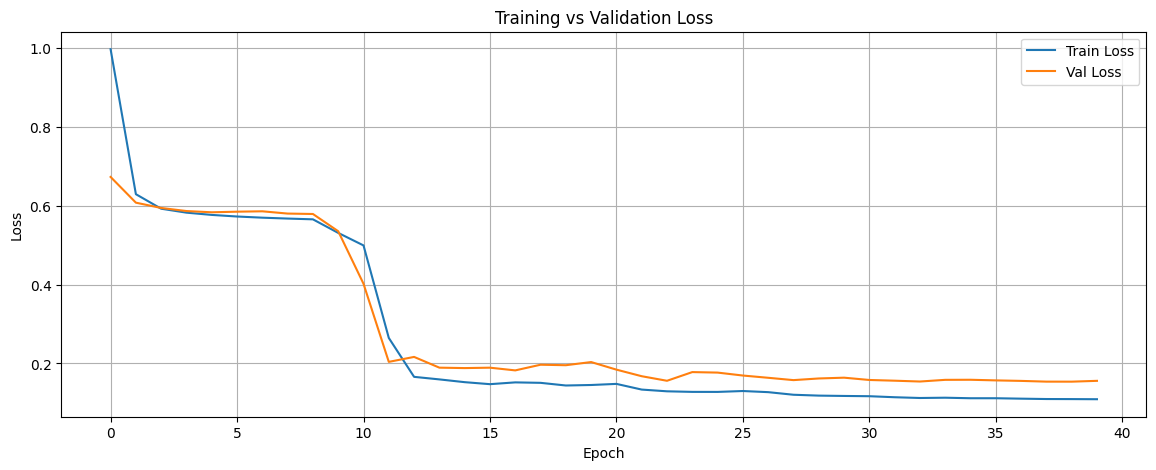

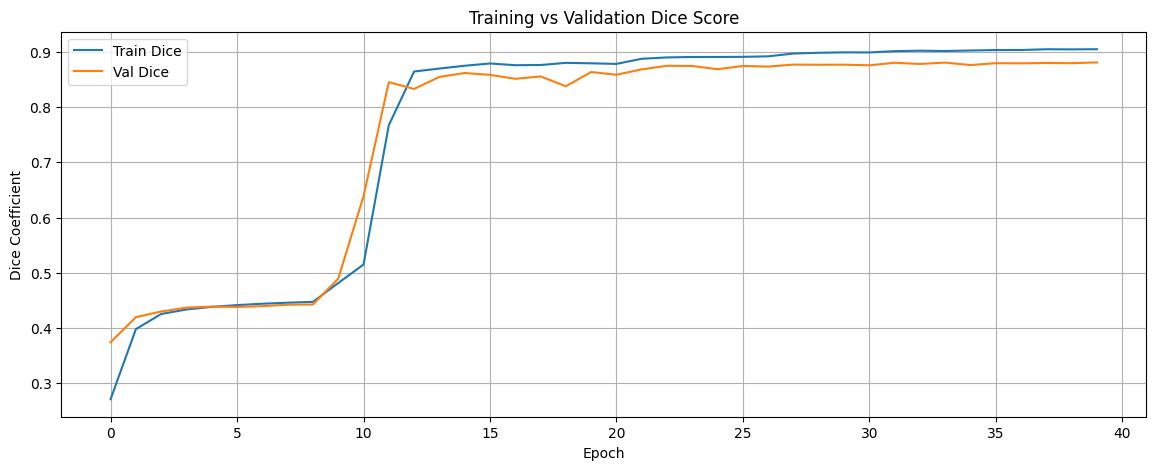

In [13]:
import matplotlib.pyplot as plt

def plot_history(history_dict):
    # ----- Loss curve -----
    plt.figure(figsize=(14,5))
    plt.plot(history_dict['train_loss'], label="Train Loss")
    plt.plot(history_dict['val_loss'], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)

    # ----- Dice curve -----
    plt.figure(figsize=(14,5))
    plt.plot(history_dict['train_dice'], label="Train Dice")
    plt.plot(history_dict['val_dice'], label="Val Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice Coefficient")
    plt.title("Training vs Validation Dice Score")
    plt.legend()
    plt.grid(True)

    plt.show()

# Call the function
plot_history(history_dict)


In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def visualize_prediction(case_id, slice_idx=80):
    # Load slices
    X = np.load(f"{OUTPUT_PATH}/{case_id}_images.npy")   # (128, 240, 240, 4)
    Y = np.load(f"{OUTPUT_PATH}/{case_id}_masks.npy")    # (128, 240, 240, 4)

    img = X[slice_idx]                                   # (240, 240, 4)
    true_mask = np.argmax(Y[slice_idx], axis=-1)         # (240, 240)

    # -------- Prepare image for model ---------
    img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).cuda()
    # shape: (1, 4, 240, 240)

    # -------- Run model inference ---------
    model.eval()
    with torch.no_grad():
        pred_logits = model(img_tensor)                  # (1, 4, 240, 240)
        pred_probs = torch.softmax(pred_logits, dim=1)
        pred_mask = torch.argmax(pred_probs, dim=1)[0].cpu().numpy()   # (240, 240)

    # -------- Plot all modalities + GT + prediction ---------
    titles = ["T1", "T1CE", "T2", "FLAIR", "Ground Truth", "Prediction"]
    images = [
        img[..., 0],      # T1
        img[..., 1],      # T1CE
        img[..., 2],      # T2
        img[..., 3],      # FLAIR
        true_mask,        # Ground truth mask
        pred_mask         # Prediction mask
    ]

    fig, ax = plt.subplots(1, 6, figsize=(15, 15))
    # plt.suptitle(f"Case: {case_id}", fontsize=18)

    for i, axis in enumerate(ax.flatten()):
        if i < 4:
            axis.imshow(images[i], cmap="gray")
        else:
            axis.imshow(images[i], cmap="nipy_spectral")

        axis.set_title(titles[i])
        axis.axis("off")

    plt.tight_layout()
    plt.show()


| Label | Color (As Seen) | Best Seen In (Primary Modality) | Notes / Meaning |
|-------|------------------|----------------------------------|------------------|
| **0** | Black            | None                             | Background / normal tissue |
| **1** | Blue / Cyan      | **T1** or **T1CE** (sometimes)   | NCR/NET – non-enhancing necrotic core |
| **2** | Light Green      | **FLAIR** (very clear), T2        | ED – edema, appears bright on FLAIR/T2 |
| **3** | Yellow / Pink    | **T1CE** (strongly visible)       | ET – enhancing tumor, only visible after contrast |


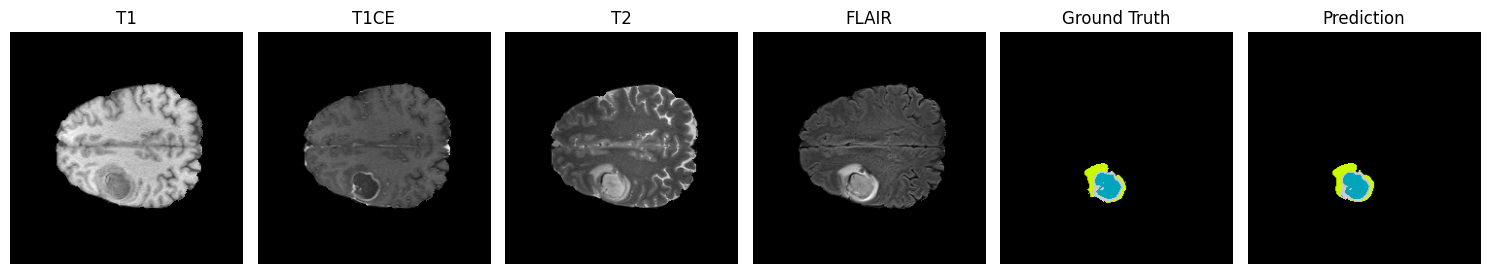

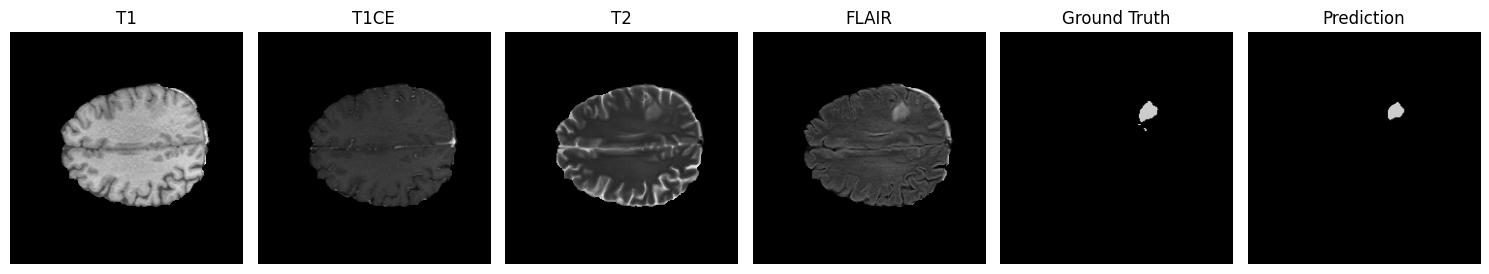

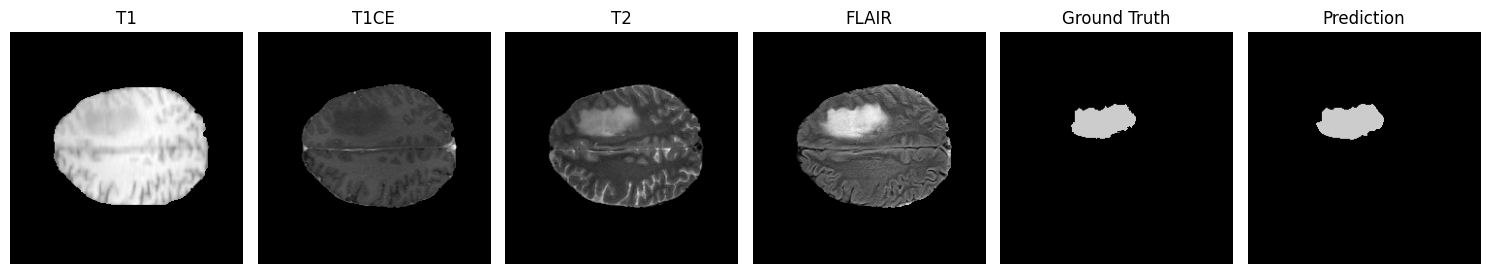

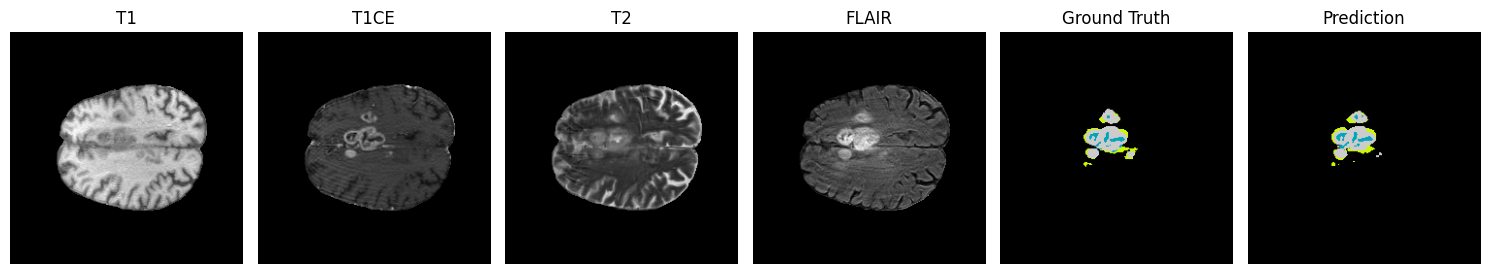

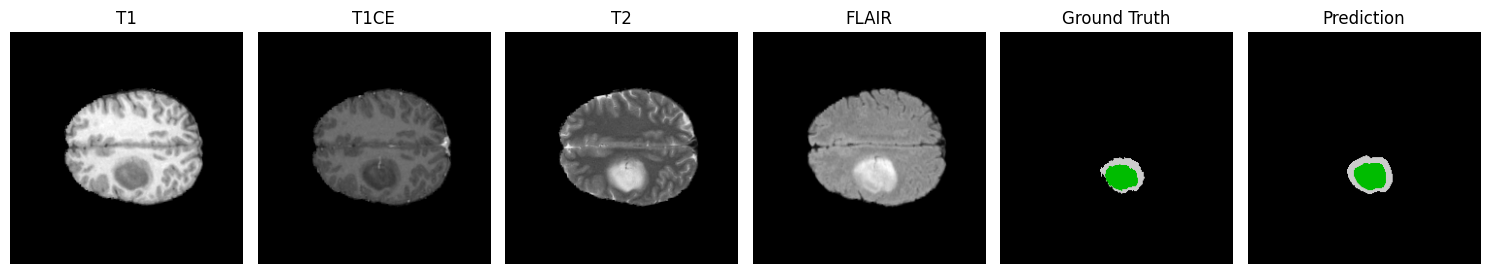

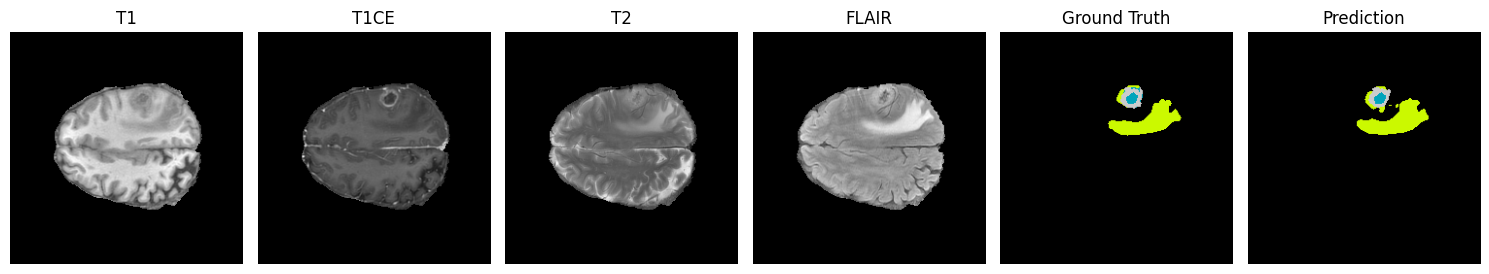

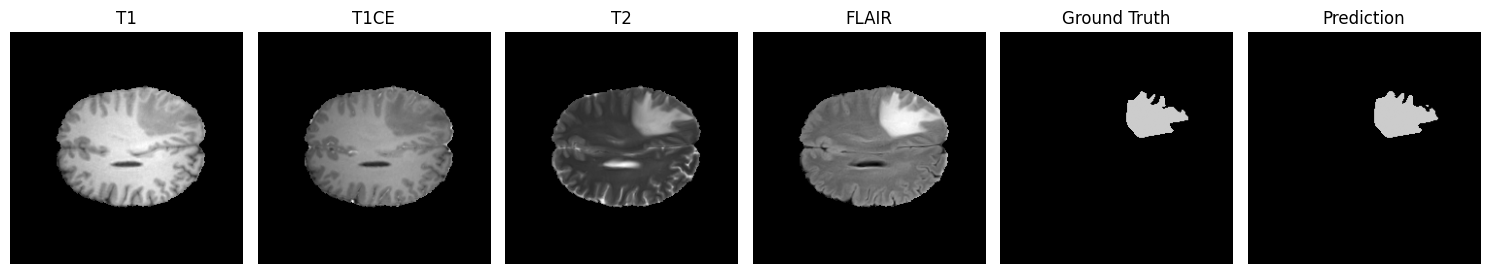

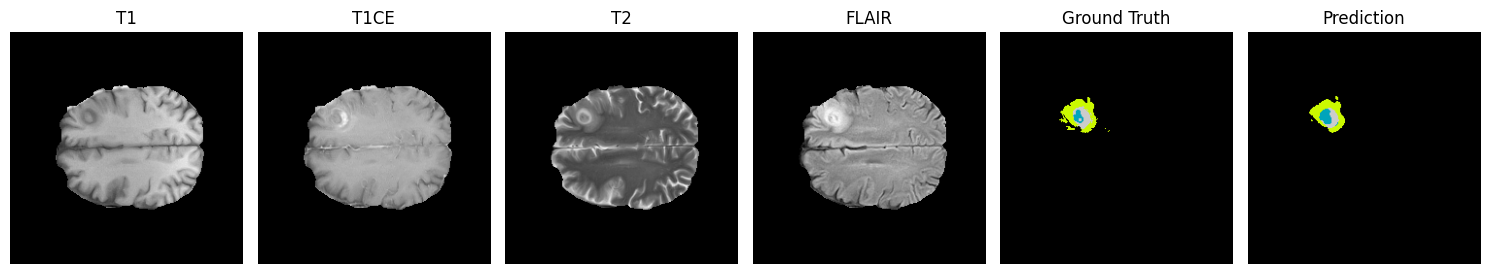

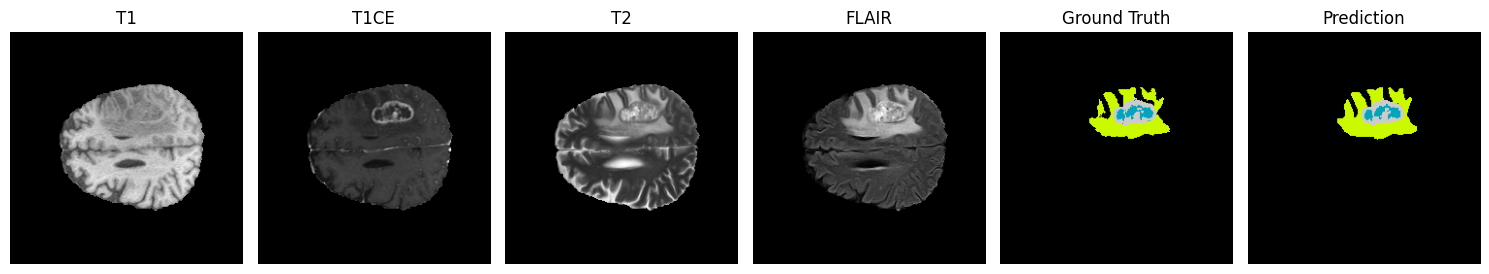

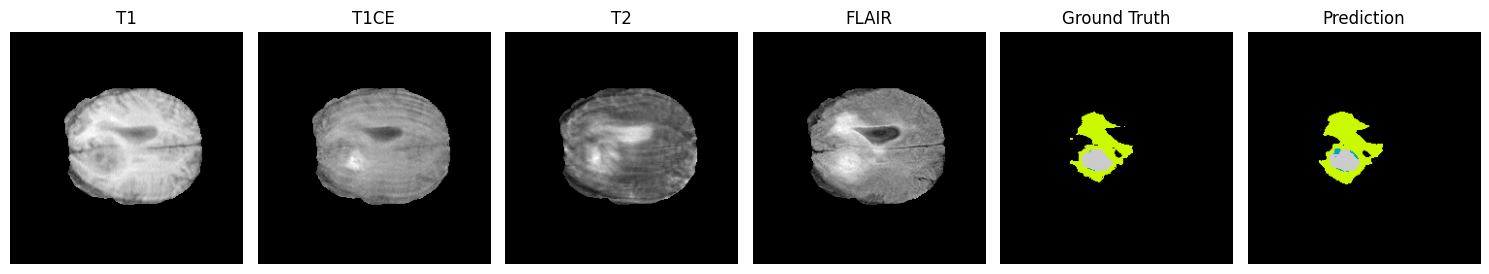

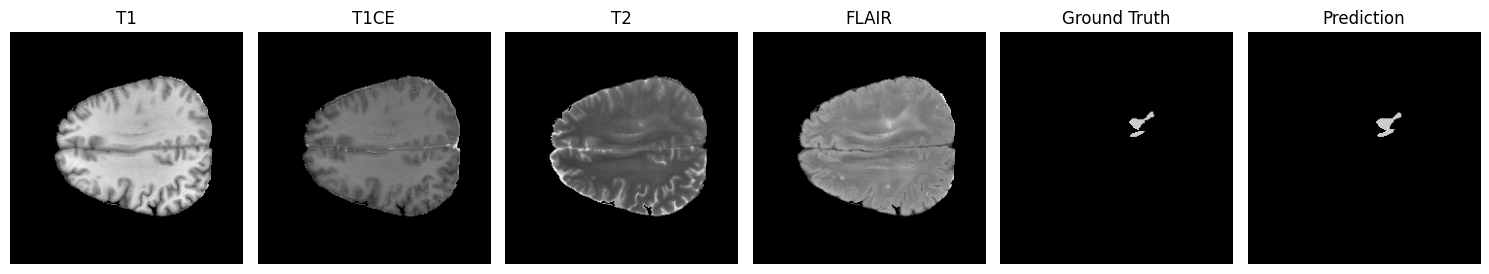

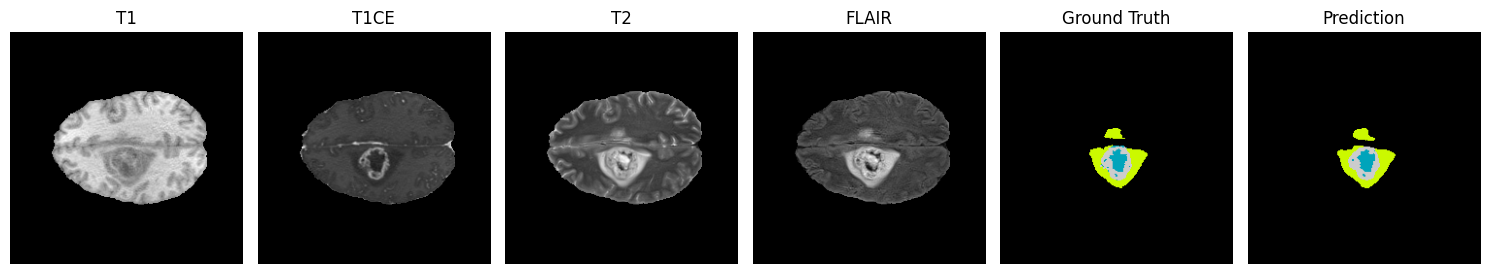

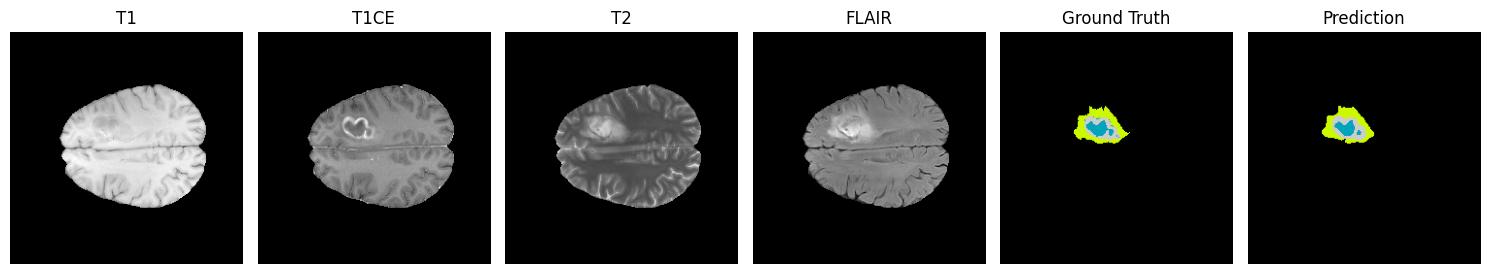

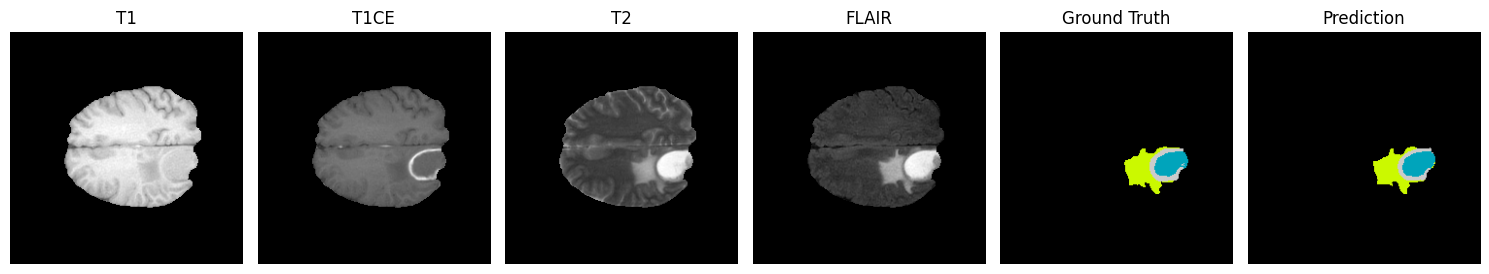

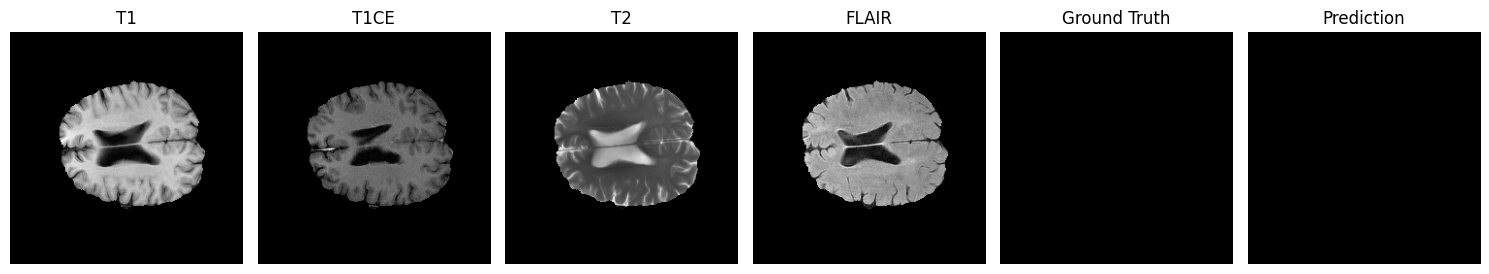

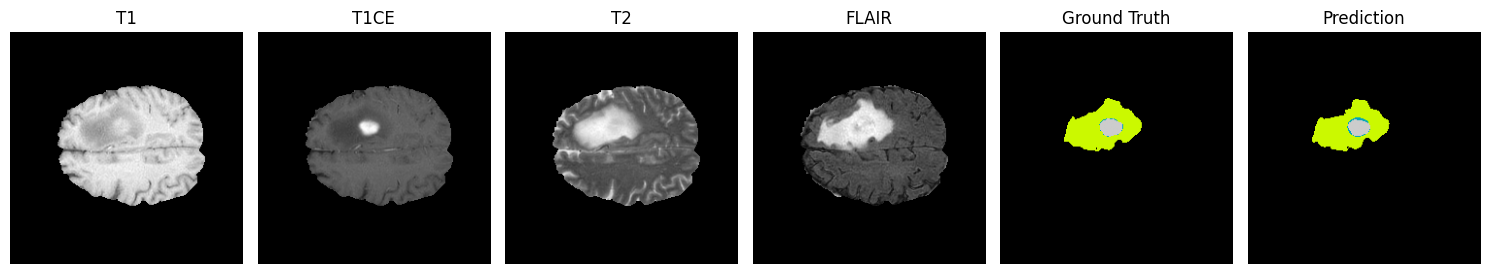

In [ ]:

import random

cases = list(test_ids)
# print(cases)
for case in cases:
    visualize_prediction(case)